In [26]:
import cobra 
import matplotlib.pyplot as plt
import pandas as pd

# Flux distribution analysis

First load the model which grows on SNM3 media. Note than in previous notebook the default media was set to be SNM3 so we only have to load it.

In [27]:
model = cobra.io.read_sbml_model("consistent_DP_SNM.xml")
print(model.slim_optimize())

0.2823653925322476


In [28]:
snm3 = pd.read_csv("SNM3.csv", sep=";")
snm3.head()

,Compound,BiGG,ModelSeed,KEGG
0,Alanine,ala__L,cpd00035,C00041
1,Arginine,arg__L,cpd00051,C00062
2,Cysteine,cys__L,cpd00084,C00097
3,Glutamic acid,glu__L,cpd00023,C00025
4,Glycine,gly,cpd00033,C00037


We now will compute all fluxes through FBA, together with their bounds using FVA. This is done for all reactions.

In [29]:
# Computing all fluxes
sol = model.optimize()

In [30]:
# Flux variability analyisis for all
fva = cobra.flux_analysis.flux_variability_analysis(model)

In [31]:
# Sticking them together
df_fluxes = fva.copy()
df_fluxes["flux"] = sol.fluxes
df_fluxes.to_excel("fluxes_DP.xlsx")
df_fluxes.head()

,minimum,maximum,flux
12DGR120tipp,0.0,0.0,0.0
12DGR140tipp,0.0,0.0,0.0
12DGR141tipp,0.0,0.0,0.0
12DGR160tipp,0.0,0.0,0.0
12DGR161tipp,0.0,0.0,0.0


Here we plot all non-zero fluxes which are around 256. They are mostly rather small with some outliears. The x-axis contains labels from fluxes which were rather high/low.

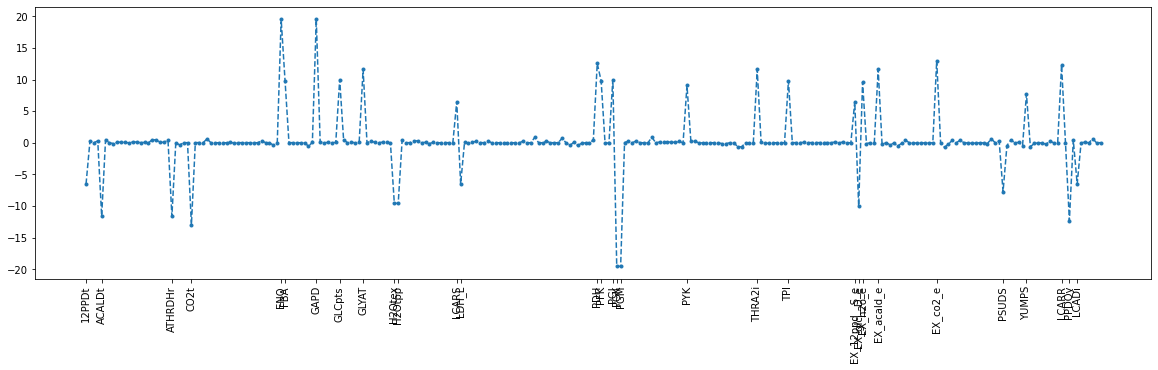

In [32]:
plt.figure(figsize=(20,5))
non_zero_flux = df_fluxes["flux"].loc[df_fluxes["flux"] != 0]
plt.plot(non_zero_flux.index, non_zero_flux, ".--")
high_vals = df_fluxes.index[df_fluxes["flux"] > 5].tolist() + df_fluxes.index[df_fluxes["flux"] < -5].tolist()
a = plt.xticks(high_vals, rotation=90)

## Plotting exchange fluxes

We will plot the bounds for the exchange fluxes such that the organism still achives maximal growth. This is done with FVA, we recompute them here for convecnience but can also be extracted from previous list.

In [33]:
# Exchange fluxes fva, for all non-zero exchanges
fva_ex = model.summary(fva=1.0)
fva_ex = fva_ex.to_frame()

In [34]:
fva_ex.head()

,reaction,metabolite,factor,flux,minimum,maximum
EX_12ppd__S_e,EX_12ppd__S_e,12ppd__S_e,-1.0,0.000000,-16.853028,0.000000
EX_26dap__M_e,EX_26dap__M_e,26dap__M_e,-1.0,0.027345,0.027345,0.027345
EX_4abz_e,EX_4abz_e,4abz_e,-1.0,0.000183,0.000183,0.000183
EX_LalaDgluMdap_e,EX_LalaDgluMdap_e,LalaDgluMdap_e,-1.0,0.000000,0.000000,0.000000
EX_acald_e,EX_acald_e,acald_e,-1.0,-18.485001,-72.389595,0.000000


In [35]:
# Get necessary values for plotting
x = []
y_fluxes = []
y_min_flux = []
y_max_flux = []
for _, data in fva_ex.iterrows():
    id = str(data.metabolite[:-2])
    f = data.factor*data.flux 
    f_min = data.factor*data.minimum 
    f_max = data.factor*data.maximum

    if not (f_min == 0 and f_max == 0):
        for j in range(len(snm3)):
            ide = str(snm3.iloc[j][1]) + "_e"
            if ide == id + "_e":
                x.append(str(snm3.iloc[j][0]))
                y_fluxes.append(f)
                y_min_flux.append(f_min)
                y_max_flux.append(f_max)


In [36]:
len(x)

37

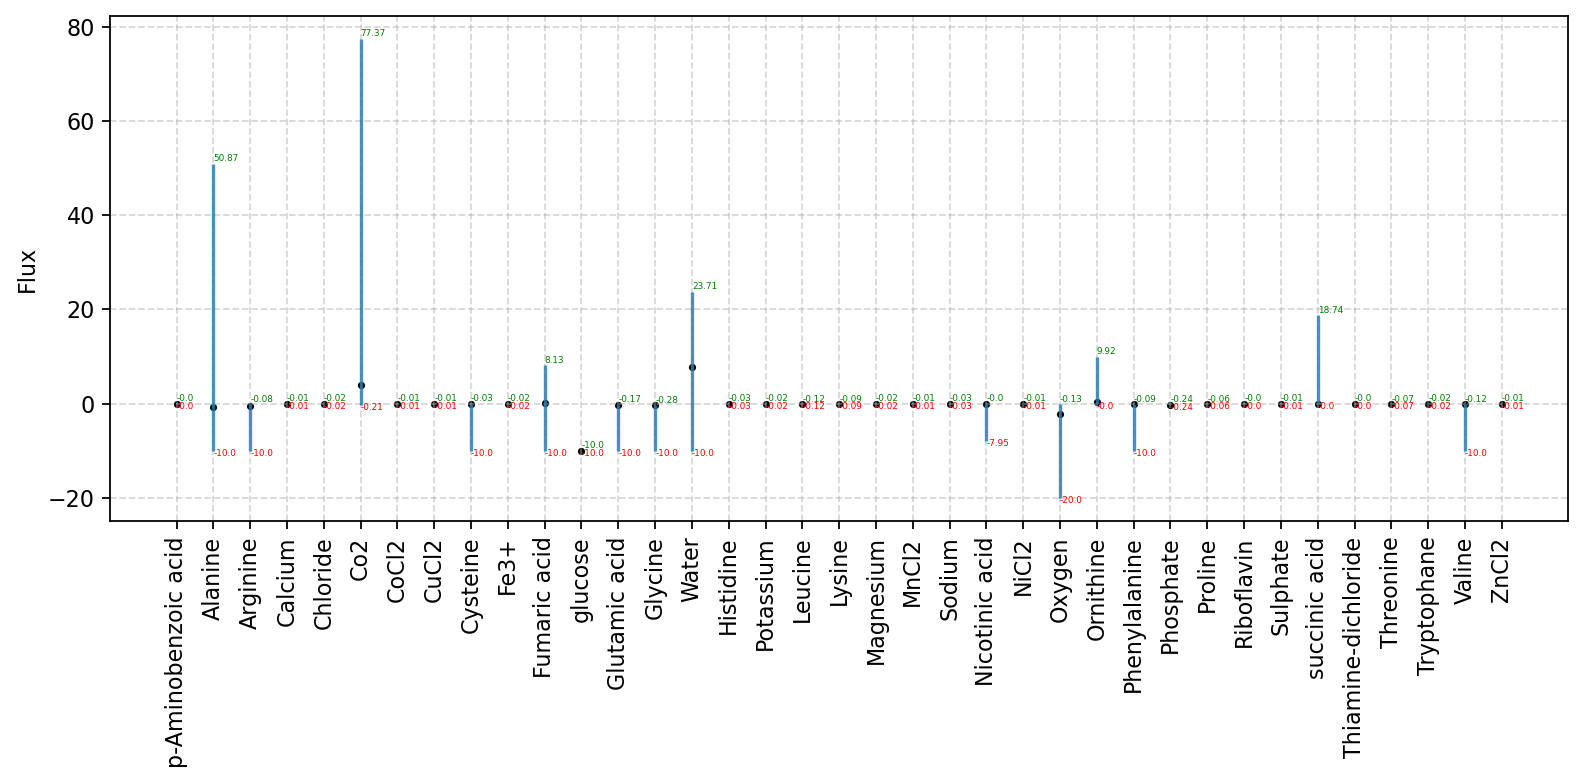

In [37]:
# Draw plot
title_font = {'fontname':'Arial', 'size':'12', 'color':'black', 'weight':'normal'} 
fig = plt.figure(figsize=(10,5), dpi= 160)
plt.vlines(x=x, ymin=y_min_flux, ymax=y_max_flux, alpha=0.8, color="C0")

# Plot FBA flux value as black dot
plt.scatter(x=x, y= y_fluxes, color="black",s=5)

#Plot maximum/minimum value in green
for y_min, x1, y_max in zip(y_min_flux, x, y_max_flux):
    t = plt.text(x1,y_min+0.1, round(y_min, 2), horizontalalignment='left', color="green",
                verticalalignment='bottom', size=4)
    t = plt.text(x1,y_max-1.5, round(y_max, 2), horizontalalignment='left', color="red",
                verticalalignment='bottom', size=4)

# Decorations    
#plt.title('Exchange flux range', **title_font)

plt.xticks(x,rotation=90)
plt.grid(linestyle='--', alpha=0.5)
plt.ylabel("Flux")
fig.tight_layout()
#plt.gcf().subplots_adjust(bottom=0.1)
plt.show()
fig.savefig("ex_flux_DP_RM.pdf")